In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


In [2]:
import pathlib
import numpy as np

import matplotlib.pyplot as plt

import torch
from torch import nn

import datasets
from transformers import AutoTokenizer

/home/adam/miniconda3/envs/lima/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# import model.rotator_lima3 as rotator
# subpath = '20240422.11:52:35-batch_size_1024'

# import model.rotator_multihead_local_coordinate as rotator
# subpath = '20240422.02:23:48-batch_size_1024'
# batch_num = 10000

# import model.rotator_multireslima_rotating_history as rotator
# subpath = '20240422.02:12:51-batch_size_1024'


subpath = '20240422.02:12:51-batch_size_1024' #for report
subpath = '20240422.18:17:15-batch_size_1024' #rotator_lima3, mse
# subpath = '20240424.00:15:13-batch_size_1024' #rotator_lima3, triplet loss
subpath = '20240424.14:29:05-batch_size_1024' #rotator_lima3, triplet+mse
# subpath = '20240424.18:17:26-batch_size_1024' # rotator_lima3_5, double LN
subpath = '20240424.18:22:33-batch_size_1024' # rotator_lima3, mse+squared_triplet

batch_num = 5000

In [4]:
folder_path = pathlib.Path('data/limanet/')

model = torch.load(folder_path/subpath/f'batch_{batch_num}-model.pt').cpu()

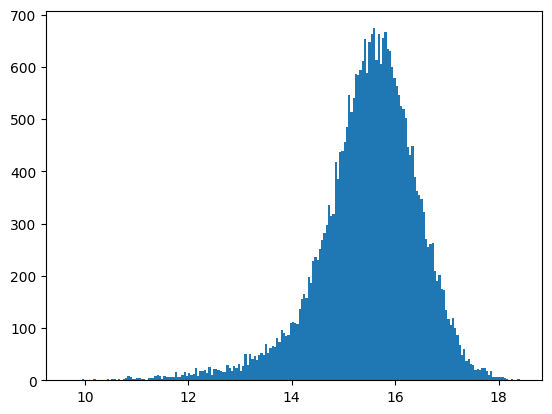

In [5]:
reals = model.predictor.embedding_real.weight
imags = model.predictor.embedding_imag.weight
norms = torch.concat([reals, imags], dim=1).norm(dim=1).detach().cpu().numpy()
fig = plt.figure()
_ = plt.hist(norms, bins=200)
fig.savefig(f'param_dist-batch_{batch_num}.png')
# fig.savefig('overtrain_param_dist.png')

In [6]:
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

In [7]:
index = norms.argsort()
tokenizer.convert_ids_to_tokens(index[-1:-6:-1])

['##zumi', 'kanye', '##eis', 'ciudad', '[unused960]']

In [8]:
model

Rotator(
  (limas): ModuleList(
    (0-2): 3 x Multihead_Lima(
      (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
  )
  (initial_history): ParameterList(
      (0): Parameter containing: [torch.float32 of size 16x1x128]
      (1): Parameter containing: [torch.float32 of size 16x1x128]
      (2): Parameter containing: [torch.float32 of size 16x1x128]
  )
  (angle_embedding): Embedding(30522, 128)
  (predictor): Output(
    (embedding_real): Embedding(30522, 128)
    (embedding_imag): Embedding(30522, 128)
  )
)

In [9]:
dataset = datasets.load_dataset('bookcorpus')
dataset['train'][:3]

{'text': ['usually , he would be tearing around the living room , playing with his toys .',
  'but just one look at a minion sent him practically catatonic .',
  "that had been megan 's plan when she got him dressed earlier ."]}

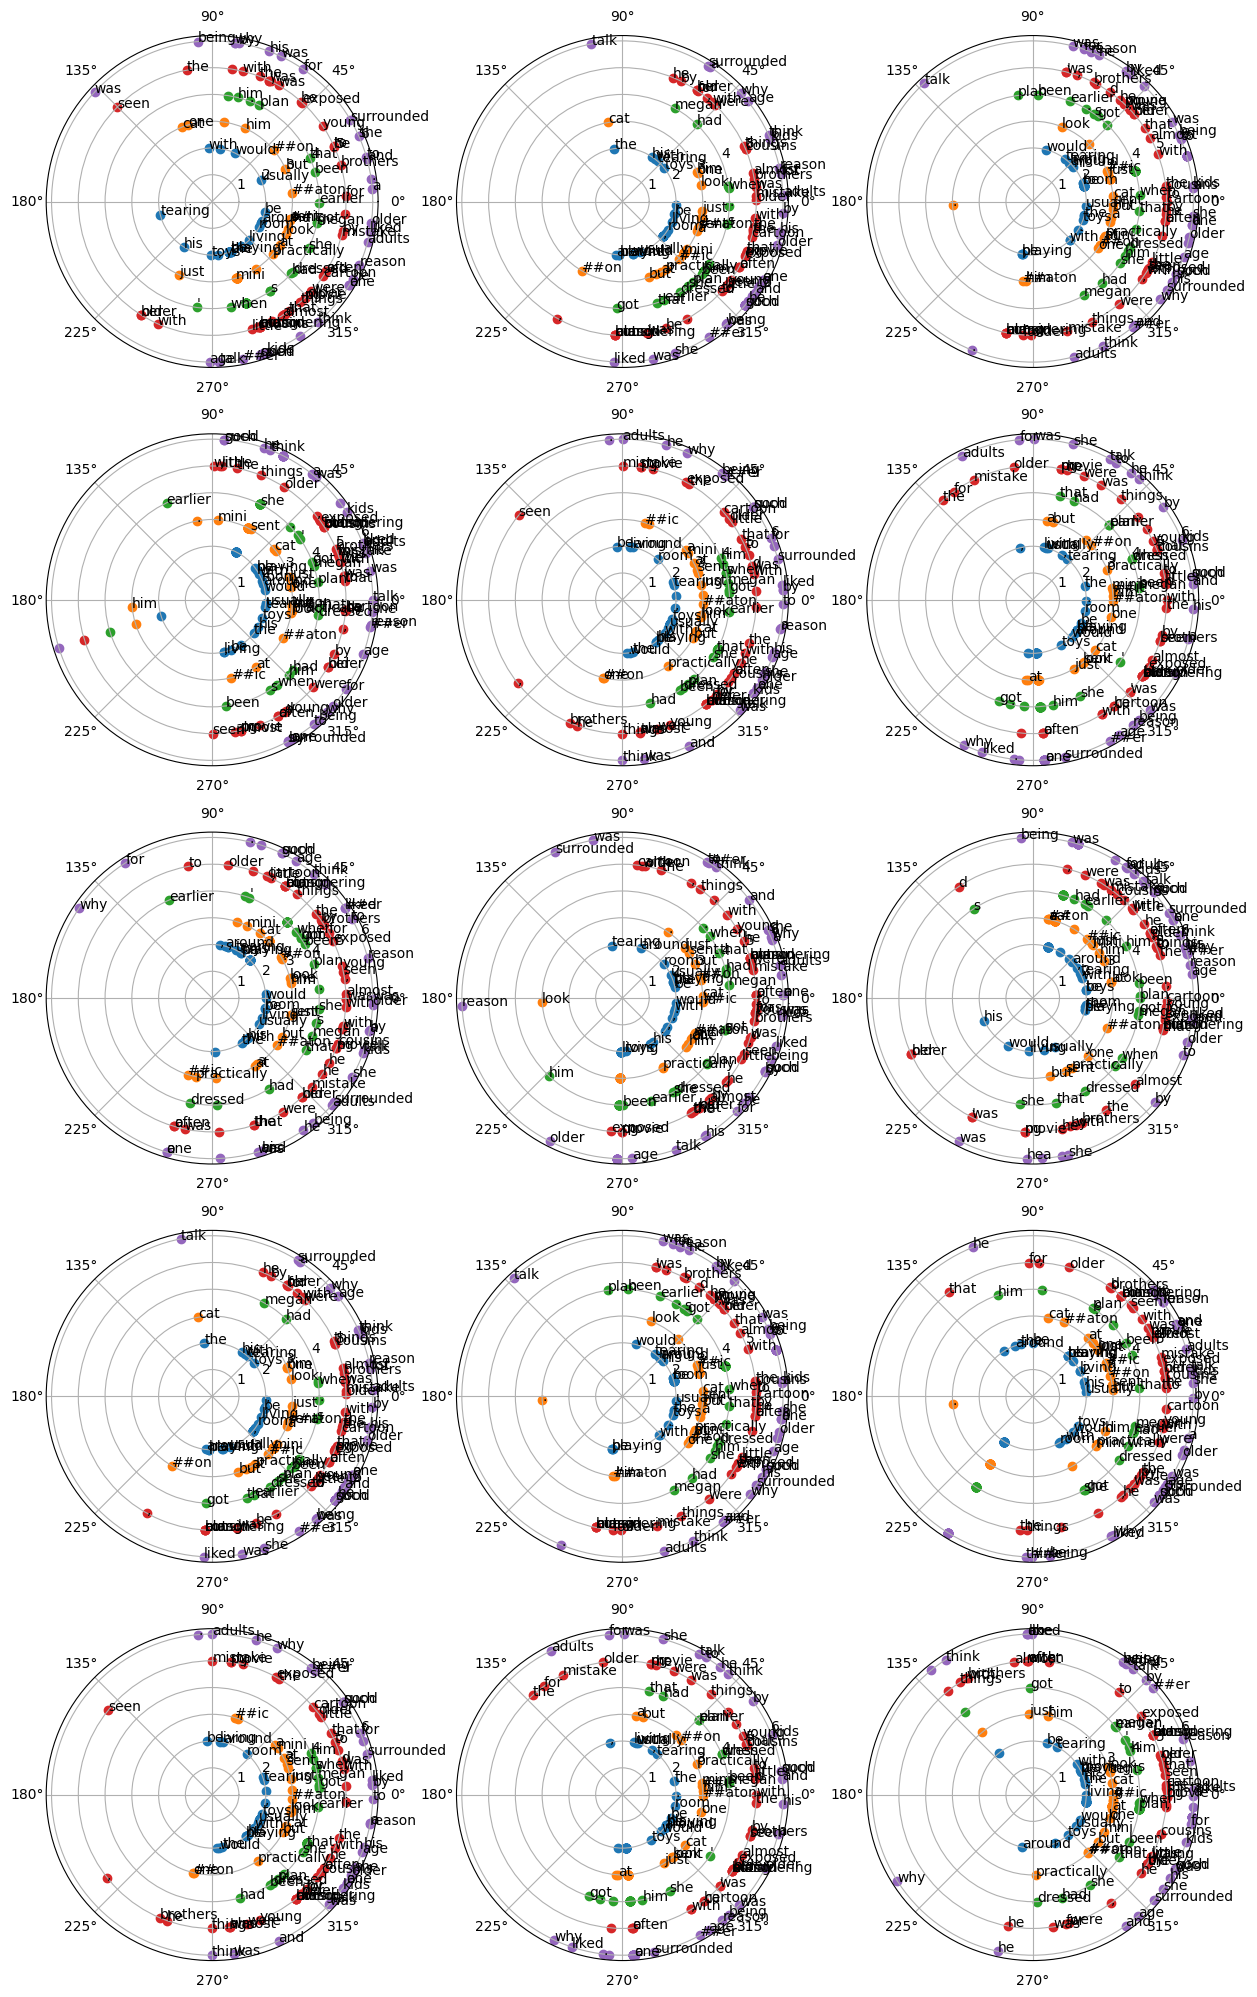

In [10]:
# word angles

samples = dataset['train'][:5]['text']

tokenized = tokenizer(samples, padding=True, return_tensors='pt')
# print(tokenized)

input_ids = tokenized['input_ids'].numpy()
angles = model.angle_embedding(tokenized['input_ids']).detach().numpy()
angles.shape

rows = 3
columns = 5

fig, axes = plt.subplots(columns, rows, figsize=[rows*5,columns*5], subplot_kw=dict(projection='polar'))

for k, (input_id, angle) in enumerate(zip(input_ids, angles)):
    sequence = tokenizer.convert_ids_to_tokens(input_id, skip_special_tokens=True)
    
    for i in range(columns):
        for j in range(rows):
            a = angle[:, j*rows+i]
            r = np.full_like(a, k+2)
            axes[i,j].scatter(a, r)

            for t, x, y in zip(sequence, a,r):
                axes[i,j].annotate(t, (x,y))

fig.savefig('word_angle.png')

In [11]:
# fig.savefig('fig.png')

/home/adam/miniconda3/envs/lima/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/adam/miniconda3/envs/lima/lib/python3.12/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/home/adam/miniconda3/envs/lima/lib/python3.12/site-packages/matplotlib/text.py:1461: ComplexWarning: Casting complex values to real discards the imaginary part
  x = float(self.convert_xunits(x))
/home/adam/miniconda3/envs/lima/lib/python3.12/site-packages/matplotlib/text.py:1463: ComplexWarning: Casting complex values to real discards the imaginary part
  y = float(self.convert_yunits(y))
/home/adam/miniconda3/envs/lima/lib/python3.12/site-packages/matplotlib/text.py:753: ComplexWarning: Casting complex values to real discards the imaginary part
  posx = float(self.convert_xunits(self._x))
/h

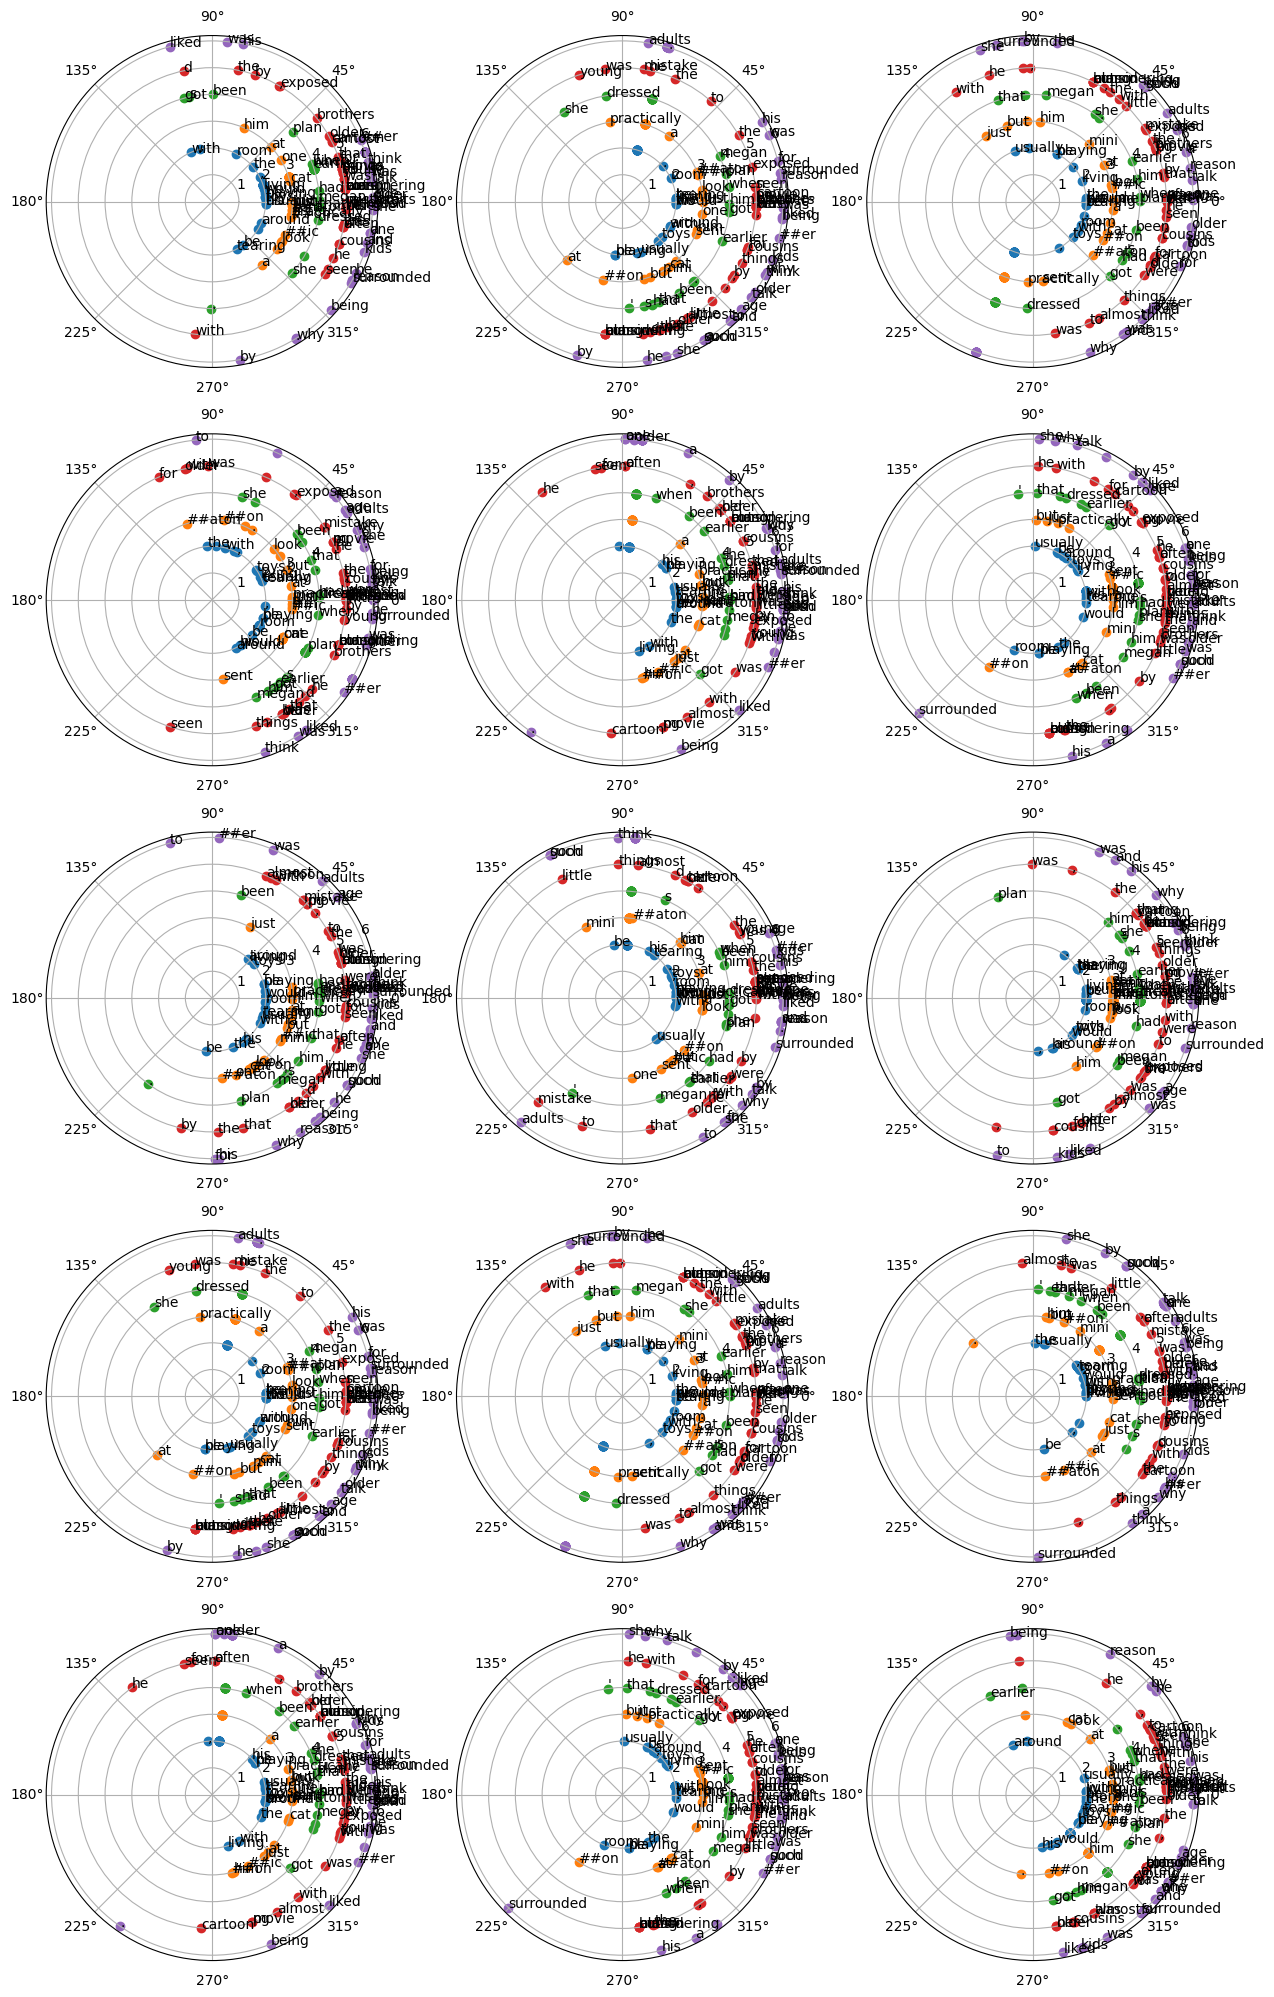

In [12]:
# word vectors

samples = dataset['train'][:5]['text']

tokenized = tokenizer(samples, padding=True, return_tensors='pt')
# print(tokenized)

input_ids = tokenized['input_ids'].numpy()
angles = model.predictor.all_word_embeddings()[tokenized['input_ids']].detach().numpy()
angles.shape

rows = 3
columns = 5

fig, axes = plt.subplots(columns, rows, figsize=[rows*5,columns*5], subplot_kw=dict(projection='polar'))

for k, (input_id, angle) in enumerate(zip(input_ids, angles)):
    sequence = tokenizer.convert_ids_to_tokens(input_id, skip_special_tokens=True)
    
    for i in range(columns):
        for j in range(rows):
            a = angle[:, j*rows+i]
            r = np.full_like(a, k+2)
            axes[i,j].scatter(a, r)

            for t, x, y in zip(sequence, a,r):
                axes[i,j].annotate(t, (x,y))

In [13]:
import sklearn.metrics.pairwise as pairwise

In [14]:
# nearest words, word vectors
target_word = 'he'
num_printing = 30

metric = 'euclidean'
metric = 'cosine'


emb = model.predictor.all_word_embeddings()
emb = torch.concat([emb.real, emb.imag], dim=1).detach().numpy()
target_word_id = tokenizer.encode(target_word, add_special_tokens=False)
dist = pairwise.pairwise_distances(emb[target_word_id], emb, metric=metric)

print('word vectors:\n')
print(tokenizer.convert_ids_to_tokens(dist.argsort()[0, :num_printing]))


emb = model.angle_embedding.weight.detach().numpy()
target_word_id = tokenizer.encode(target_word, add_special_tokens=False)
dist = pairwise.pairwise_distances(emb[target_word_id], emb, metric=metric)

print('\nword angles:\n')
print(tokenizer.convert_ids_to_tokens(dist.argsort()[0, :num_printing]))

word vectors:

['he', '##nsk', 'ladder', 'interpretations', 'faux', '##nco', 'assassin', '##ndo', '家', 'cas', '##idae', 'hickory', 'yanking', '201', '[MASK]', 'namesake', 'humans', 'politically', 'т', '##男', 'excuse', 'khz', 'theology', 'freestyle', 'poking', 'grafton', 'rom', 'hub', 'courtship', 'cinemas']

word angles:

['he', 'specimens', 'christianity', 'lawsuits', 'showcase', '[unused216]', 'underway', '157', 'triple', 'lasers', '##,', 'natalia', '##pot', '##av', '[unused576]', '##cd', 'candace', 'preschool', '3', 'caf', 'dignitaries', '46', '##hrer', 'prefers', 'canning', 'astonishment', '##uer', '##raphy', 'cache', 'activists']


In [15]:
# dist = pairwise.pairwise_distances(emb, emb).detach()
# np.fill_diagonal(dist, np.nan)
# np.nanmin(dist), np.nanmax(dist)